# Multi-class Classification: Logistic Regression

This notebook contains the first part of the Programming Exercise 3 of the Andrew Ng's course on Coursera.

Implement a multi-class classification model using Logistic Regression to recognize handwritten numbers (0-9). We will extend the LogReg model from exercise 2. 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Loading and visualizing data

In [3]:
# Load the data (in .mat format)
from scipy.io import loadmat
data = loadmat('ex3data1.mat')

In [4]:
# The matrix X contains a set of 5000 grayscale training images (20px x 20px) where each pixel is a float representing the grayscale intensity. 
# The 400 pixels (20x20) of each image are actually unrolled into a 400 dimensions array 
# Each row of X represents a single image. Each column a pixel of all images

# X = [         px1  px2  px3  px4  ... px400 
# image 1 =>    0.0, 0.0, 0.2, 0.4  ...  0.0        
# image 2 =>    0.0, 0.1, 0.2, 0.2  ...  0.0        
# image 3 =>    0.0, 0.0, 0.0, 0.2  ...  0.0        
# ...           ...
# image 5000 => 0.0, 0.0, 0.1, 0.2  ...  0.0

# The matrix X contains a set of 5000 grayscale training images (20px x 20px) where each pixel is a float representing the grayscale intensity. 
# The 400 pixels (20x20) of each image are actually unrolled into a 400 dimensions array 
# Each row of X represents a single image. Each column a pixel of all images

# Y = [         number
# image 1 =>    1     
# image 2 =>    7        
# image 3 =>    3       
# ...           ...
# image 5000 => 9

X = data['X']
y = data['y']
X.shape, y.shape

((5000L, 400L), (5000L, 1L))

In [5]:
# Helper functions to visualize the data (from https://github.com/kaleko/CourseraML/blob/master/ex3/ex3.ipynb)

import scipy.misc #Used to show matrix as an image
import random #To pick random images to display
import matplotlib.cm as cm #Used to display images in a specific colormap

def getDatumImg(row):
    # Function that is handed a single np array with shape 1x400, creates an image object from it, and returns it
    width, height = 20, 20
    square = row[0:].reshape(width,height)
    return square.T

def displayData(indices_to_display = None):
    # Function that picks 100 random rows from X, creates a 20x20 image from each, then stitches them together into a 10x10 grid of images, and shows it
    width, height = 20, 20
    nrows, ncols = 10, 10
    if not indices_to_display:
        indices_to_display = random.sample(range(X.shape[0]), nrows*ncols)
        
    big_picture = np.zeros((height*nrows,width*ncols))
    
    irow, icol = 0, 0
    for idx in indices_to_display:
        if icol == ncols:
            irow += 1
            icol  = 0
        iimg = getDatumImg(X[idx])
        big_picture[irow*height:irow*height+iimg.shape[0],icol*width:icol*width+iimg.shape[1]] = iimg
        icol += 1
    fig = plt.figure(figsize=(6,6))
    img = scipy.misc.toimage( big_picture )
    plt.imshow(img,cmap = cm.Greys_r)

array([[ 1,  6, 10,  4,  7,  7,  4,  7,  8,  4],
       [ 4,  2,  4,  9,  7,  2, 10,  4,  6,  9],
       [ 9, 10,  3,  9,  5,  2,  6,  5,  7,  6],
       [ 5,  9,  9,  2,  3,  7,  6,  4, 10,  1],
       [ 8,  4, 10,  6,  3,  3,  5,  3, 10,  5],
       [ 9,  5,  6,  6,  8,  9,  4,  5,  9,  9],
       [ 8,  4,  2,  1,  4,  8,  9,  4,  8,  1],
       [ 9,  4,  6,  5,  2, 10,  6,  5,  1, 10],
       [10,  2,  8,  5,  9, 10,  5,  9,  6, 10],
       [ 6,  8,  8,  1,  7,  5,  8,  9,  1,  8]], dtype=uint8)

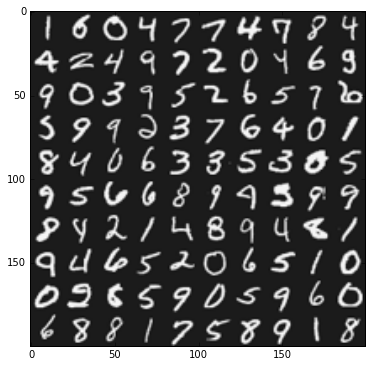

In [6]:
# let's visualize 100 random rows of X with the corresponding labels in y
indices_to_display = random.sample(range(X.shape[0]),100)
displayData(indices_to_display)
y[indices_to_display].reshape(10,10)

## Vectorized Logistic Regression Model

We will reuse much of the code from exercise 2. 

The gradient calculations is updated to a fully vectorized version.

In [7]:
# define the hypotehsis function
def h(X, theta):
    return sigmoid(X*theta.T)

In [8]:
# cost function
def computeCost(theta, X, y, lmbda):
    # convert to matrices to use notation of algebra operations
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    
    # compute first, second and regularization terms
    first = np.multiply(-y, np.log(h(X, theta)))
    second = np.multiply((1 - y), np.log(1 - h(X, theta)))
    reg = lmbda/(2*len(X)) * np.sum(np.power(theta[:,1:theta.shape[1]],2)) # all thetas except theta[0]
        
    return np.sum(first - second) / len(X) + reg

In [10]:
# function that computes the gradient for each theta parameter (single step, not the gradient algorithm)
def computeGradient(theta, X, y, lmbda):
    # convert to matrices to use notation of algebra operations
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    
    # init vars
    num_parameters = int(theta.ravel().shape[1])
    gradient = np.zeros(num_parameters)
       
    # compute gradient for each parameter theta (vectorized version)
    gradient = ((X.T * (h(X, theta) - y)) / len(X)).T + ((lmbda / len(X)) * theta)

    # theta0 is not regularized
    gradient[0, 0] = np.sum(np.multiply(h(X, theta) - y, X[:,0])) / len(X)
        
    return gradient

## One-vs-all classification

In [11]:
#Insert a column of 1's to X
X = np.insert(X, 0 , 1, axis=1)

In [13]:
import scipy.optimize

def one_vs_all_classification(X, y, num_labels, lmbda):
    num_rows = X.shape[0]
    params = X.shape[1]
    
    # k X (n + 1) array for the parameters of each of the k classifiers
    all_theta = np.zeros((num_labels, params + 1))
    
    # insert a column of ones at the beginning for the intercept term
    X = np.insert(X, 0, values=np.ones(rows), axis=1)
    
    # labels are 1-indexed instead of 0-indexed
    for i in range(1, num_labels + 1):
        theta = np.zeros(params + 1)
        y_i = np.array([1 if label == i else 0 for label in y])
        y_i = np.reshape(y_i, (rows, 1))
        
        # minimize the objective function
        fmin = minimize(fun=cost, x0=theta, args=(X, y_i, learning_rate), method='TNC', jac=gradient)
        all_theta[i-1,:] = fmin.x
    
    return all_theta

(5000L, 1L)